In [1]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.decomposition import PCA

df = pd.read_csv('A3/train.csv', index_col='ArticleId')
X_train = df['Text']
df['Category'].replace(['tech', 'entertainment'], [0,1], inplace=True)
Y_train = df['Category']

df_test = pd.read_csv('A3/test.csv', index_col='ArticleId')
X_test = df_test['Text']
df_test['Category'].replace(['tech', 'entertainment'], [0,1], inplace=True)
Y_test = df_test['Category']

temp_complete_test = pd.concat([X_train, X_test])

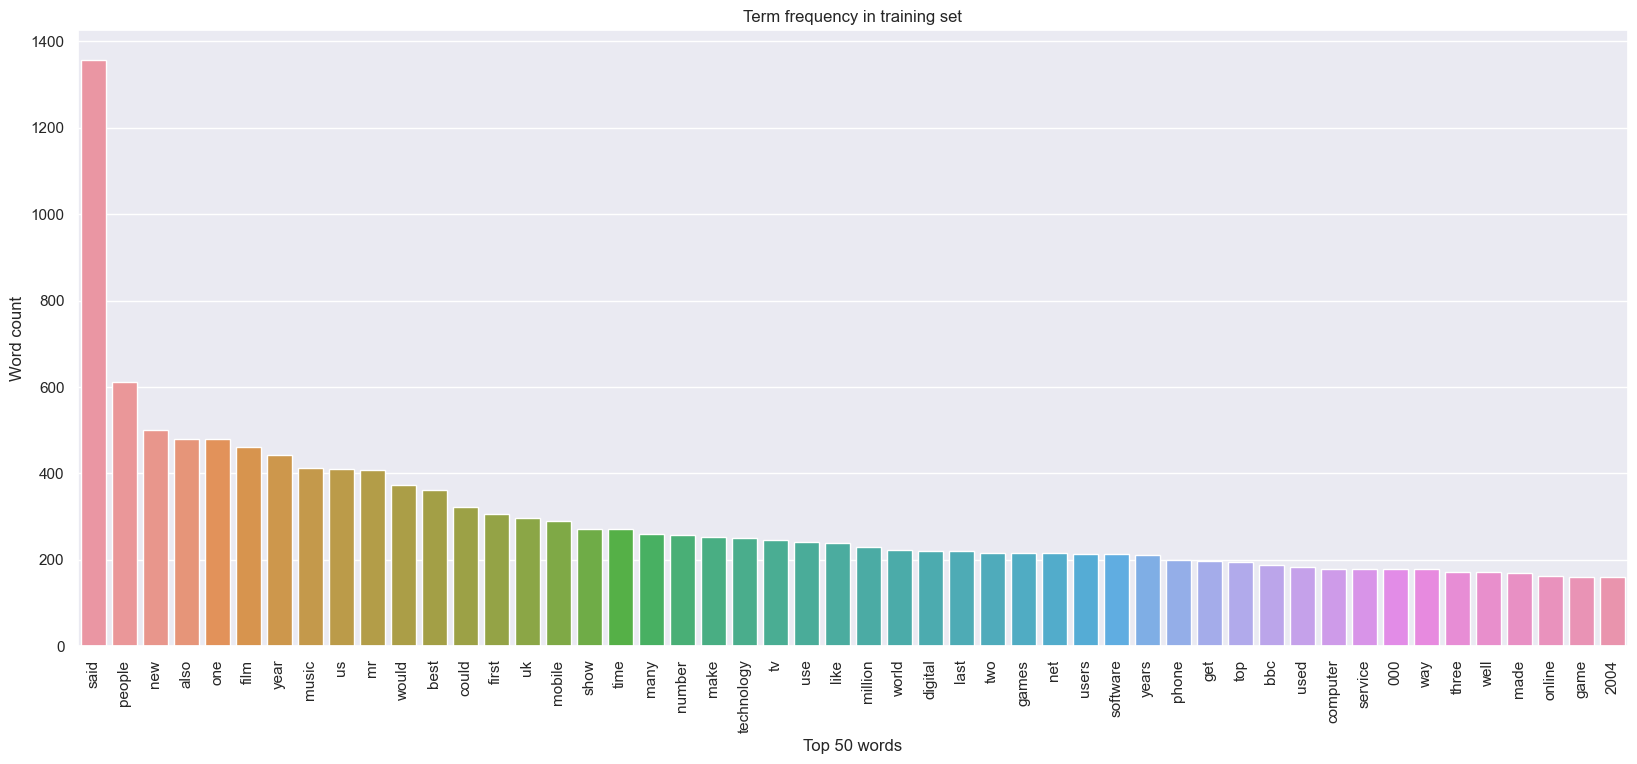

In [2]:
# Frequency count for dataset
vectorizer = CountVectorizer()
vectorizer.fit(temp_complete_test)
# Encode document
vector = vectorizer.transform(temp_complete_test)
prep_X_count = pd.DataFrame(vector.toarray(), columns=sorted(vectorizer.vocabulary_), index=temp_complete_test.index)

prep_X_train_count = prep_X_count[:428]
prep_X_test_count = prep_X_count[428:]

train_sum = prep_X_train_count.sum().sort_values(ascending=False)
test_sum = prep_X_test_count.sum().sort_values(ascending=False)

train_top_50 = train_sum.head(50)
sns.set_style('whitegrid')
sns.set(rc = {'figure.figsize':(20,8)})
plot = sns.barplot(x=train_top_50.index, y=train_top_50.values)
plot.set_xlabel('Top 50 words')
plot.set_ylabel('Word count')
plot.set_title('Term frequency in training set')
plt.xticks(rotation = 90)
plt.show()

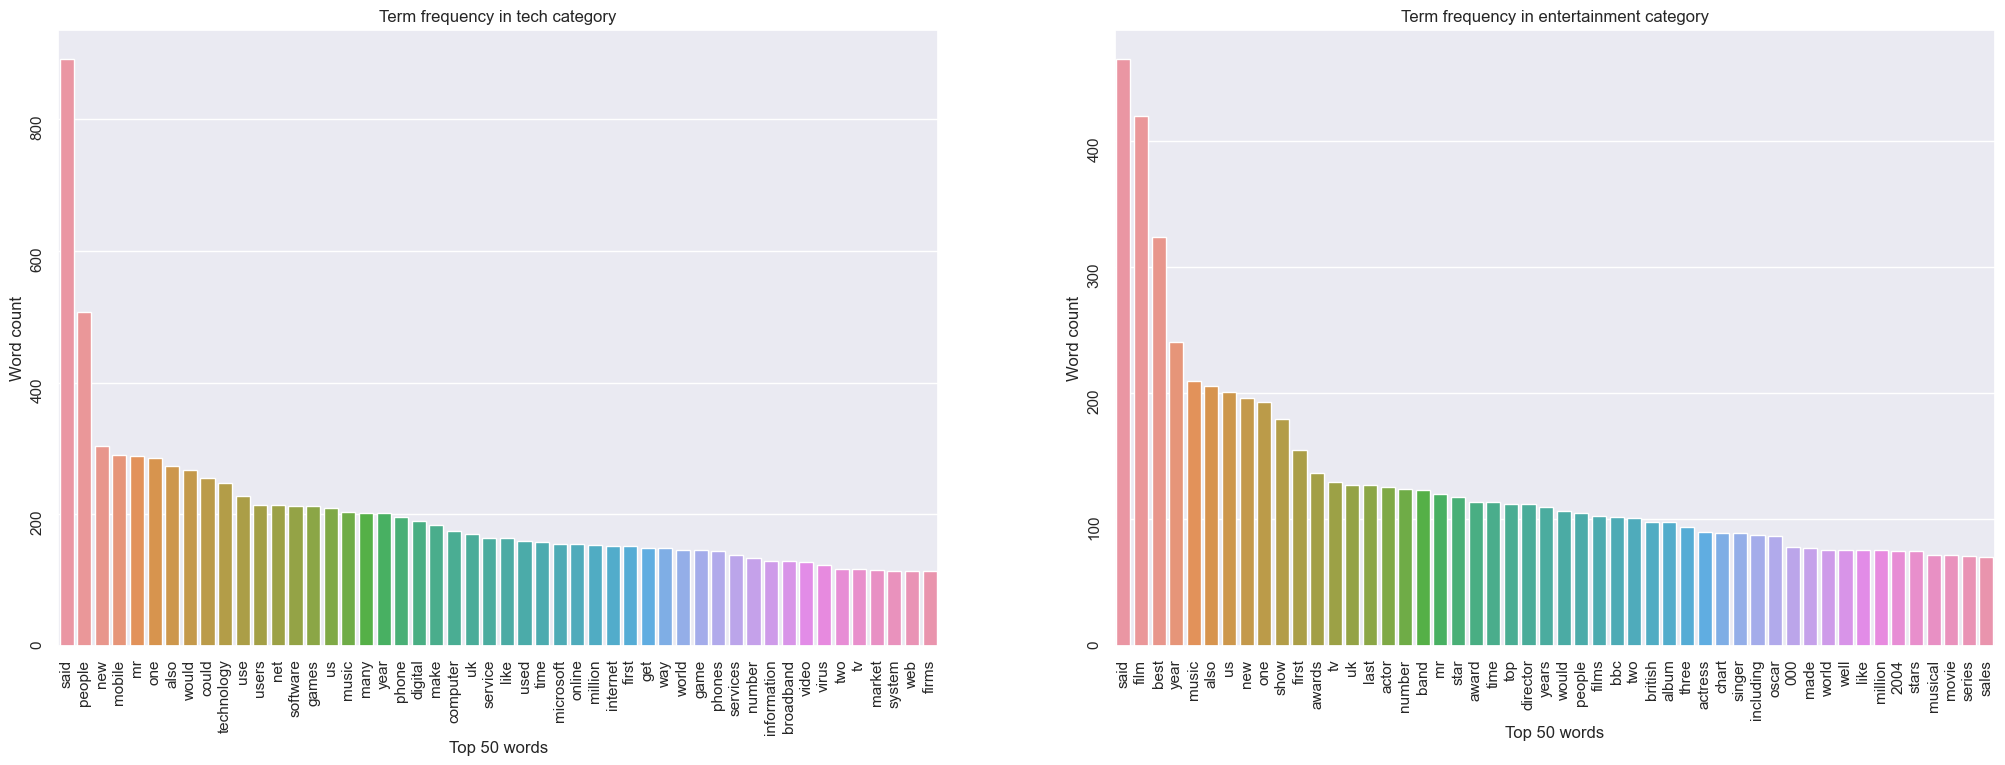

In [3]:
train_label_group = Y_train.groupby(Y_train)
train_tech, train_entertain = train_label_group.get_group(0).index, train_label_group.get_group(1).index

train_tech_sum = prep_X_count.loc[train_tech].sum().sort_values(ascending=False)
train_entertain_sum = prep_X_count.loc[train_entertain].sum().sort_values(ascending=False)

train_top_50_tech = train_tech_sum.head(50)
train_top_50_entertain = train_entertain_sum.head(50)

fig, ax = plt.subplots(ncols=2, figsize=(25, 8))
ax[0] = sns.barplot(x=train_top_50_tech.index, y=train_top_50_tech.values, ax=ax[0])
ax[0].set_xlabel('Top 50 words')
ax[0].set_ylabel('Word count')
ax[0].set_title('Term frequency in tech category')
ax[0].tick_params(labelrotation=90)

ax[1] = sns.barplot(x=train_top_50_entertain.index, y=train_top_50_entertain.values, ax=ax[1])
ax[1].set_xlabel('Top 50 words')
ax[1].set_ylabel('Word count')
ax[1].set_title('Term frequency in entertainment category')
ax[1].tick_params(labelrotation=90)
plt.show()

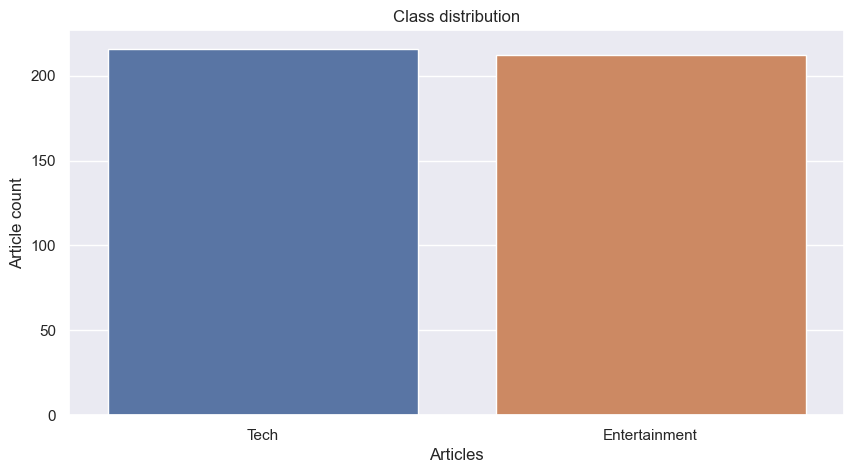

In [4]:
sns.set(rc = {'figure.figsize':(10,5)})
plot = sns.barplot(x=['Tech', 'Entertainment'], y=[train_tech.size, train_entertain.size])
plot.set_xlabel('Articles')
plot.set_ylabel('Article count')
plot.set_title('Class distribution')
plt.show()

In [5]:
vectorizer = TfidfVectorizer()
vectorizer.fit(X_train)

# encode document
vector = vectorizer.transform(X_test)
prep_X_test = pd.DataFrame(vector.toarray(), columns=sorted(vectorizer.vocabulary_), index=X_test.index)

vector = vectorizer.transform(X_train)
prep_X_train = pd.DataFrame(vector.toarray(), columns=sorted(vectorizer.vocabulary_), index=X_train.index)
print(prep_X_test.shape)
print(prep_X_train.shape)

(106, 13518)
(428, 13518)


# Task 2(a)

## Naive Bayes

In [6]:
from sklearn.naive_bayes import MultinomialNB
import math

# alpha = 1.0 ==> Laplace Smoothing; not perfectly balanced data ==> fit_prior = TRUE
nb_classifier = MultinomialNB(alpha = 1.0, fit_prior = True)

# Fit data to classifier
nb_classifier.fit(prep_X_train_count, Y_train)

# Get log-likelihood of features given a class, i.e. P(x_i|y)
log_like_class0 = nb_classifier.feature_log_prob_[0]
log_like_class1 = nb_classifier.feature_log_prob_[1]

# Get indices of likelihood given class, from largest likelihood to smallest
# By negation rule, smallest items are originally the largest
max_index_class0 = np.argsort(-log_like_class0)
max_index_class1 = np.argsort(-log_like_class1)

# Top-20 most identifiable words over class 0
top20_class0 = np.array(prep_X_train_count.columns)[max_index_class0][0:20]

# Top-20 most identifiable words over class 1
top20_class1 = np.array(prep_X_train_count.columns)[max_index_class1][0:20]

print(top20_class0)
print(top20_class1)

# Calculate the values of the ratio between likelihoods for class 0
# P(x_i|y = 0) / P(x_i|y = 1)
ratio_class0 = np.exp(log_like_class0) / np.exp(log_like_class1)

# Calculate the values of the ratio between likelihoods for class 1
# P(x_i|y = 1) / P(x_i|y = 0)
ratio_class1 = np.exp(log_like_class1) / np.exp(log_like_class0)

# Sort indices of ratios, from largest ratio to smallest
# By negation rule, smallest items are originally the largest
max_index_ratio_class0 = np.argsort(-ratio_class0)
max_index_ratio_class1 = np.argsort(-ratio_class1)

# Top-20 words that maximise the quantity
top20_ratio_class0 = np.array(prep_X_train_count.columns)[max_index_ratio_class0][0:20]
top20_ratio_class1 = np.array(prep_X_train_count.columns)[max_index_ratio_class1][0:20]

print(top20_ratio_class0)
print(top20_ratio_class1)


['said' 'people' 'new' 'mobile' 'mr' 'one' 'also' 'would' 'could'
 'technology' 'use' 'users' 'net' 'software' 'games' 'us' 'music' 'many'
 'year' 'phone']
['said' 'film' 'best' 'year' 'music' 'also' 'us' 'new' 'one' 'show'
 'first' 'awards' 'tv' 'last' 'uk' 'actor' 'number' 'band' 'mr' 'star']
['users' 'software' 'microsoft' 'mobile' 'broadband' 'virus' 'firms' 'pc'
 'spam' 'phones' 'gadget' 'net' 'consumer' 'mobiles' 'gadgets' 'machines'
 'windows' 'technologies' 'systems' 'pcs']
['actress' 'singer' 'oscar' 'stars' 'aviator' 'band' 'nominated' 'rock'
 'festival' 'album' 'nominations' 'charles' 'chart' 'foxx' 'oscars'
 'starring' 'singles' 'jamie' 'swank' 'comedy']


## (i)
The top-20 most identifiable words that are most likely to occur inthe articles over class ```tech``` and ```entertainment``` is:

|Rank|tech| |Rank| entertainment |
|:---:|:---:|---|:---:|:---:|
|1|said||1|said|
|2|people||2|film|
|3|new||3|best|
|4|mobile||4|year|
|5|mr||5|music|
|6|one||6|also|
|7|also||7|us|
|8|would||8|new|
|9|could||9|one|
|10|technology||10|show|
|11|use||11|first|
|12|users||12|awards|
|13|net||13|tv|
|14|software||14|last|
|15|games||15|uk|
|16|us||16|actor|
|17|music||17|number|
|18|many||18|band|
|19|year||19|mr|
|20|phone||20|star|

Note that in the code, we can compare the likelihood on log scale because it is monotonic.

## (ii)
The top-20 words that maximise the following quantity
$\begin{align*}
\frac{\mathbb{P}(X_w = 1|Y = y)}{\mathbb{P}(X_w = 1|Y \neq y)}
\end{align*}$:

|Rank|Y = tech| |Rank|Y = entertainment|
|:---:|:---:|---|:---:|:---:|
|1|users||1|actress|
|2|software||2|singer|
|3|microsoft||3|oscar|
|4|mobile||4|stars|
|5|broadband||5|aviator|
|6|virus||6|band|
|7|firms||7|nominated|
|8|pc||8|rock|
|9|spam||9|festival|
|10|phones||10|album|
|11|gadget||11|nominations|
|12|net||12|charles|
|13|consumer||13|chart|
|14|mobiles||14|foxx|
|15|gadgets||15|oscars|
|16|machines||16|starring|
|17|windows||17|singles|
|18|technologies||18|jamie|
|19|systems||19|swank|
|20|pcs||20|comedy|

The (ii) top-20 words that maximise the quantity is better than the (i) top-20 most identifiable words that are most likely to occur over 2 classes. It is because (i) calculate the corresponding likelihood, but not comparing the likelihood to that of other classes. We do not know whether the word will be more likely to be in class `tech` or `entertainment`. In contrast, (ii) actually calculates the relative likelihood. If the ratio is greater than 1, it means that the word will be more likely to be in the numerator class than that of the denominator class. Therefore, the lists of (ii) will better decribe the class.

# Task 3(a)

     portion  training accuracy  testing accuracy
0.1      0.1           0.831956          0.870370
0.3      0.3           0.988067          0.983333
0.5      0.5           0.990566          0.983607
0.7      0.7           0.995283          0.991736
0.9      0.9           0.995283          0.991736


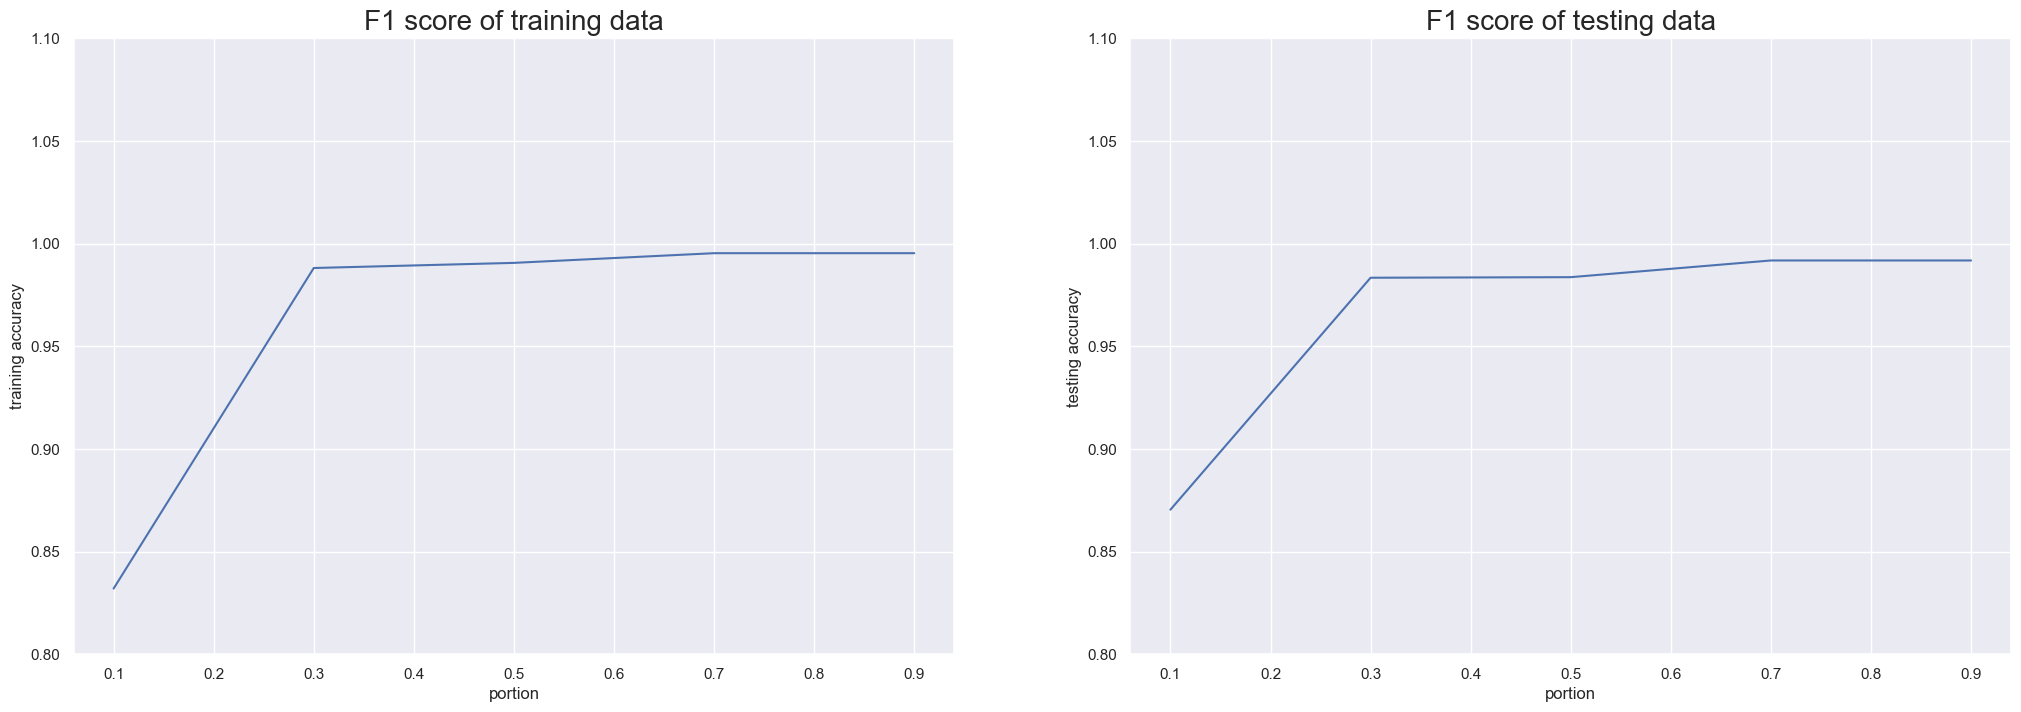

In [7]:
from sklearn.metrics import f1_score


# alpha = 1.0 ==> Laplace Smoothing; not perfectly balanced data ==> fit_prior = TRUE
nb_classifier = MultinomialNB(alpha = 1.0, fit_prior = True)

# Fit data to classifier
nb_classifier.fit(prep_X_train_count, Y_train)


# Fit m portion and train 5 nb models
# Divide portion
def train_nb_models(m, prep_X_train_count):
    nb_models = []
    for portion in m:
        training_data = prep_X_train_count[:round(portion * prep_X_train_count.shape[0])]
        training_class = Y_train[:round(portion * Y_train.shape[0])]
        nb_classifier = MultinomialNB(alpha = 1.0, fit_prior = True)
        nb_classifier.fit(training_data, training_class)
        nb_models.append(nb_classifier)
    return nb_models


def get_f1_score(m, nb_models, training_X, training_Y, testing_X, testing_Y):
    training_f1_list = []
    testing_f1_list = []
    
    for i in range(len(m)):        
        training_prediction = nb_models[i].predict(training_X)
        testing_prediction = nb_models[i].predict(testing_X)
        
        training_f1 = f1_score(training_Y, training_prediction)
        testing_f1 = f1_score(testing_Y, testing_prediction)
        
        training_f1_list.append(training_f1)
        testing_f1_list.append(testing_f1)
        
    return (training_f1_list, testing_f1_list)
    
def plot_curve(dataframe):
    
    fig, ax = plt.subplots(ncols=2, figsize=(25, 8))

    ax[0] = sns.lineplot(data=dataframe, x = "portion", y="training accuracy", ax = ax[0])
    ax[0].set(ylim=(0.8, 1.1))
    ax[0].set_title('F1 score of training data', fontsize=20)

    ax[1] = sns.lineplot(data=dataframe, x = "portion", y="testing accuracy", ax = ax[1])
    ax[1].set(ylim=(0.8, 1.1))
    ax[1].set_title('F1 score of testing data' ,fontsize=20)

    
def main():
    m = [0.1, 0.3, 0.5, 0.7, 0.9]
    test_X_count = prep_X_count[428:]
    nb_models = train_nb_models(m, prep_X_train_count)
    training_f1, testing_f1 = get_f1_score(m, nb_models, prep_X_train_count, Y_train, test_X_count, Y_test)
    
    f1 = {"portion":m, "training accuracy":training_f1, "testing accuracy":testing_f1}
    f1 = pd.DataFrame(data=f1, index = m)
    print(f1)
    
    plot_curve(f1)
    
main()

# Task 3(b)

In [8]:
from sklearn.model_selection import cross_val_score

# Create models with different hyper-parameters
alphas = np.arange(0, 6, 1)
nb_models = []

for index in range(len(alphas)):
    nb_classifier = MultinomialNB(alpha = alphas[index], fit_prior = True, force_alpha = True)
    nb_classifier.fit(prep_X_train_count, Y_train)
    nb_models.append(nb_classifier)
    
# get validation score
validation_score_dict = {}
for index in range(len(nb_models)):
    validation_score_dict[alphas[index]] = cross_val_score(nb_models[index], prep_X_train_count, Y_train, cv = 5,
                                                          scoring = "f1")

# Get mean validation score
for key in validation_score_dict.keys():
    validation_score_dict[key] = np.mean(validation_score_dict[key])

# Test f1_score
testing_score_dict = {}
test_X_count = prep_X_count[428:]

for index in range(len(nb_models)):
    testing_prediction = nb_models[index].predict(test_X_count)
    testing_f1 = f1_score(Y_test, testing_prediction)
    testing_score_dict[alphas[index]] = testing_f1
    
    
print(validation_score_dict)
print(testing_score_dict)

data_dict = {"validation f1":validation_score_dict.values(), "testing f1":testing_score_dict}

f1_df = pd.DataFrame(data=data_dict, index = alphas)
print(f1_df)

C:\Users\User\anaconda3\lib\site-packages\sklearn\naive_bayes.py:907: RuntimeWarning: divide by zero encountered in log
  self.feature_log_prob_ = np.log(smoothed_fc) - np.log(
C:\Users\User\anaconda3\lib\site-packages\sklearn\naive_bayes.py:907: RuntimeWarning: divide by zero encountered in log
  self.feature_log_prob_ = np.log(smoothed_fc) - np.log(
C:\Users\User\anaconda3\lib\site-packages\sklearn\utils\extmath.py:189: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
C:\Users\User\anaconda3\lib\site-packages\sklearn\naive_bayes.py:907: RuntimeWarning: divide by zero encountered in log
  self.feature_log_prob_ = np.log(smoothed_fc) - np.log(
C:\Users\User\anaconda3\lib\site-packages\sklearn\utils\extmath.py:189: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
C:\Users\User\anaconda3\lib\site-packages\sklearn\naive_bayes.py:907: RuntimeWarning: divide by zero encountered in log
  self.feature_log_prob_ = np.log(smoothed_fc) - np.log(
C:\Users\User\an

{0: 0.0, 1: 0.9814449457815222, 2: 0.978598089838345, 3: 0.9759036144578314, 4: 0.9734939759036145, 5: 0.9709080223332354}
{0: 0.0, 1: 0.9917355371900827, 2: 0.9833333333333333, 3: 0.9747899159663865, 4: 0.9747899159663865, 5: 0.9747899159663865}
   validation f1  testing f1
0       0.000000    0.000000
1       0.981445    0.991736
2       0.978598    0.983333
3       0.975904    0.974790
4       0.973494    0.974790
5       0.970908    0.974790


The value of ```alpha``` is a hyper-parameter for a Naive Bayes model. ```alpha``` represents the additive smoothing parameter. We test 6 different values of alpha, namely [0, 1, 2, 3, 4, 5]. 0 represents there is no smoothing parameter.

After fitting the model with 6 different alpha values, we find out that when ```alpha = 0```, the corresponding average f1 score for both validation and testing data is 0. It is because there could in both validation and testing sets, there could be new features (words) that are not in the training set. As a result, the likelihood for those instances will be 0. And log(0) is not defined. Apart from ```alpha = 0```, we see that the average f1 score peaks at ```alpha = 1``` for both validation and testing data. The f1 score has a downward trend when the value of ```alpha``` increses.